# Importing Libraries

In [2]:
import os
import pandas as pd
import numpy as np
import shutil

import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from keras.models import Sequential
from keras import layers
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, Activation, MaxPool2D
from keras.layers import  Input, GlobalAveragePooling2D
from keras.models import Model

from keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

from tensorflow.keras.preprocessing import image

import warnings 
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Making Directories

In [3]:
home_path = "/kaggle/working/"

# Create train and validation directories
original_train_path = r'/kaggle/input/car-damage/train_zip/train'

train_path = os.path.join(home_path,'train')
os.mkdir(train_path)  # Gives Error if the Folder already Exists

val_path = os.path.join(home_path,'valid')
os.mkdir(val_path)

all_train_path = os.path.join(home_path,'all_train')
os.mkdir(all_train_path)

test_path = os.path.join(home_path,'test_fol/images')
os.makedirs(test_path,exist_ok = True)

# Create Subdirectories
def make_subdir(main_folder,sub_folder):
    created_path = os.path.join(home_path + main_folder, sub_folder)
    os.mkdir(created_path)

main_folder_list = ['train','valid','all_train']
sub_folder_list = ['crack','scratch','tire flat','dent','glass shatter','lamp broken']

for main_folder in main_folder_list:
    for sub_folder in sub_folder_list:
        make_subdir(main_folder,sub_folder)

## Data Preparation

In [4]:
gray_path = os.path.join(home_path + 'gray_folder')
hue_folder = os.path.join(home_path + 'hue_folder')

os.makedirs(gray_path,exist_ok = True)
os.makedirs(hue_folder ,exist_ok = True)


os.makedirs(os.path.join(hue_folder,'train'),exist_ok = True)
hue_train = hue_folder + '/train'

os.makedirs(os.path.join(hue_folder,'valid'),exist_ok = True)
hue_valid = hue_folder + '/valid'

os.makedirs(os.path.join(hue_folder,'all_train'),exist_ok = True)
hue_all_train = hue_folder + '/all_train'

def make_subdir(main_folder,sub_folder):
    created_path = os.path.join(hue_folder + '/' + main_folder, sub_folder)
    os.makedirs(created_path,exist_ok=True)

main_folder_list = ['train','valid','all_train']
sub_folder_list = ['crack','scratch','tire flat','dent','glass shatter','lamp broken']

for main_folder in main_folder_list:
    for sub_folder in sub_folder_list:
        make_subdir(main_folder,sub_folder)

In [5]:
def change_to_gray():
    images_fol = os.path.join(original_train_path,'images')
    destination_path = home_path +'/gray_folder'
    hue_path = home_path + '/hue_folder'
    image_names = os.listdir(images_fol)
    for image_name in image_names:
        temp_img = cv2.imread(images_fol + '/{}'.format(image_name),0)
        cv2.imwrite(destination_path + '/{}'.format(image_name),temp_img)
        
        hue_temp_img = cv2.imread(images_fol + '/{}'.format(image_name),cv2.COLOR_RGB2HSV)
        cv2.imwrite(hue_path + '/{}'.format(image_name),hue_temp_img)
    
change_to_gray()

In [7]:
# Convering and Saving test images to test_path
def save_to_test_path():
    images_fol = '/kaggle/input/car-damage/test_zip/test/images'
    destination_path = test_path
    
    image_names = os.listdir(images_fol)
    for image_name in image_names:
        temp_img = cv2.imread(images_fol + '/{}'.format(image_name),1)
        temp_img = cv2.cvtColor(temp_img, cv2.COLOR_BGR2HSV)
        cv2.imwrite(destination_path + '/{}'.format(image_name),temp_img)
    
save_to_test_path()

In [8]:
df = pd.read_csv(original_train_path + r'/train.csv')

x = df.loc[:,'filename']
y = df.loc[:,'label']

# Splitting Labeled images into Train and Validation Data
# such that Validation data contains each label in equal ratio

x_train,x_val,y_train,y_val = train_test_split(x,y,test_size=0.1,
                                               random_state=6,
                                               stratify=y)

df_train = pd.DataFrame(columns=['filename','label'])
df_train['filename'] = x_train
df_train['label'] = y_train

df_val = pd.DataFrame(columns=['filename','label'])
df_val['filename'] = x_val
df_val['label'] = y_val

df_train.reset_index(drop=True,inplace=True)
df_val.reset_index(drop=True,inplace=True)

# Saving labeled images to newly created folders
def save_images(df):
    if df.shape[0] == 6480:
        fol = home_path + r'/train'
    elif df.shape[0] == 720:
        fol = home_path + r'/valid'
    else:
        fol = home_path + r'/all_train'

    for i in range(len(df)):
        filename = df.loc[i,'filename']

        if df.loc[i,'label'] == 1:
            shutil.copy(home_path + r'gray_folder/' + filename, fol+r'/crack')
        elif df.loc[i,'label'] == 2:
            shutil.copy(home_path + r'gray_folder/' + filename, fol+r'/scratch')
        elif df.loc[i,'label'] == 3:
            shutil.copy(home_path + r'gray_folder/' + filename, fol+r'/tire flat')
        elif df.loc[i,'label'] == 4:
            shutil.copy(home_path + r'gray_folder/' + filename, fol+r'/dent')
        elif df.loc[i,'label'] == 5:
            shutil.copy(home_path + r'gray_folder/' + filename, fol+r'/glass shatter')
        else:
            shutil.copy(home_path + r'gray_folder/' + filename, fol+r'/lamp broken')
            
def save_hue_images(df):
    if df.shape[0] == 6480:
        fol = hue_folder + r'/train'
    elif df.shape[0] == 720:
        fol = hue_folder + r'/valid'
    else:
        fol = hue_folder + r'/all_train'

    for i in range(len(df)):
        filename = df.loc[i,'filename']

        if df.loc[i,'label'] == 1:
            shutil.copy(hue_folder + '/' + filename, fol+r'/crack')
        elif df.loc[i,'label'] == 2:
            shutil.copy(hue_folder + '/' + filename, fol+r'/scratch')
        elif df.loc[i,'label'] == 3:
            shutil.copy(hue_folder + '/' + filename, fol+r'/tire flat')
        elif df.loc[i,'label'] == 4:
            shutil.copy(hue_folder + '/' + filename, fol+r'/dent')
        elif df.loc[i,'label'] == 5:
            shutil.copy(hue_folder + '/' + filename, fol+r'/glass shatter')
        else:
            shutil.copy(hue_folder + '/' + filename, fol+r'/lamp broken')


save_images(df_train)
save_images(df_val)
save_images(df[['filename','label']])

save_hue_images(df_train)
save_hue_images(df_val)
save_hue_images(df[['filename','label']])

In [9]:
val_path = home_path + r'/valid'

hue_train_path = hue_folder + r'/train'
hue_val_path = hue_folder + r'/valid'
hue_all_train_path = hue_folder + r'/all_train'
hue_test_fol = home_path + r'test_fol'

target_size = (96,96)

val_datagen = ImageDataGenerator(rescale= 1./ 255)

train_datagen = ImageDataGenerator(rescale=1./255,
                                    zoom_range=0.2,
                                    horizontal_flip = True,
                                    width_shift_range=0.4,
                                    height_shift_range=0.2,
                                    brightness_range=[0.5,1],
                                    fill_mode='nearest'
                                    )

train_generator = train_datagen.flow_from_directory(hue_train_path,
                                                    target_size= target_size,
                                                    batch_size= 36,
                                                    class_mode = 'categorical',
                                                    shuffle = True,
                                                   color_mode = 'grayscale')


val_generator = val_datagen.flow_from_directory(hue_val_path,
                                                    target_size= target_size,
                                                    batch_size= 36,
                                                    class_mode = 'categorical',
                                                    shuffle = True,
                                               color_mode = 'grayscale')


all_train_generator = val_datagen.flow_from_directory(hue_all_train_path,
                                                     target_size= target_size,
                                                     batch_size=36,
                                                     class_mode = 'categorical',
                                                     shuffle = True,
                                                     color_mode = 'grayscale')

test_generator = val_datagen.flow_from_directory(hue_test_fol,
                                                target_size = target_size,
                                                batch_size=36,
                                                class_mode = 'categorical',
                                                shuffle = False,
                                                color_mode = 'grayscale')

Found 6480 images belonging to 6 classes.
Found 720 images belonging to 6 classes.
Found 7200 images belonging to 6 classes.
Found 4800 images belonging to 1 classes.


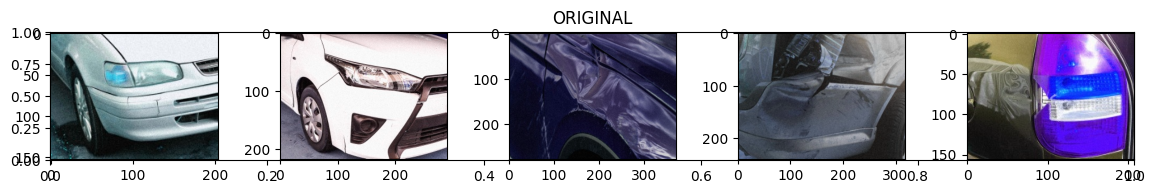

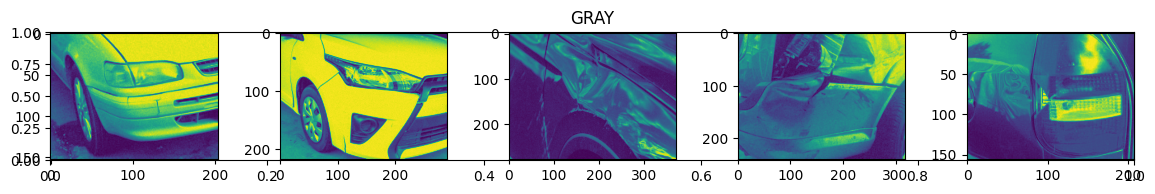

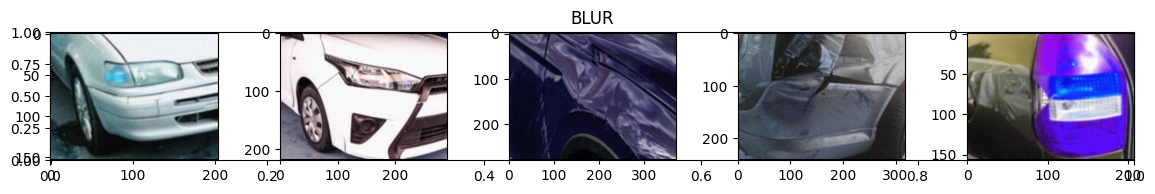

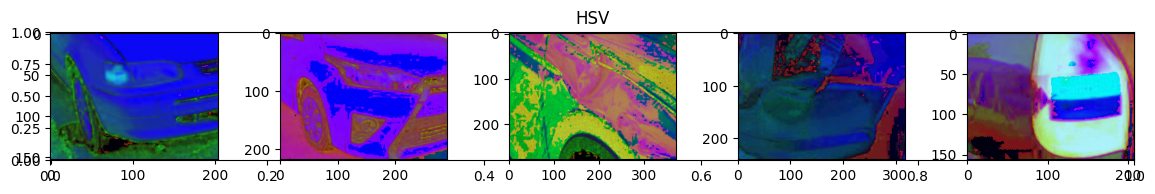

In [11]:
import random
sam_imgs = []
    
def random_imgs(fol,n):
    img_list = random.choices(os.listdir(hue_train_path + '/' + fol),k=n)
    for img_name in img_list:
        sam_imgs.append(cv2.imread(hue_train_path + '/' + fol + '/' + img_name,1))

random_imgs('crack',2)
random_imgs('dent',2)
random_imgs('lamp broken',1)

gray_imgs = []
adaptive_imgs = []
blur_imgs = []
hsv_imgs = []

# ORIGINAL
idx = 1
fig = plt.figure(figsize=(12,2))
plt.title('ORIGINAL')
for img in sam_imgs:
    gray_imgs.append(cv2.cvtColor(img,cv2.COLOR_RGB2GRAY))
    blur_imgs.append(cv2.GaussianBlur(img, (3, 3), 0))
    fig.add_subplot(1,5,idx)
    idx += 1
    plt.imshow(img)
plt.tight_layout()

# GRAY
idx = 1
fig = plt.figure(figsize=(12,2))
plt.title('GRAY')
for img in gray_imgs:
    adaptive_imgs.append(cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
                        cv2.THRESH_BINARY,11,2))
    fig.add_subplot(1,5,idx)
    idx += 1
    plt.imshow(img)
plt.tight_layout()

# # GAUSSIAN ADAPTIVE
# idx = 1
# fig = plt.figure(figsize=(12,2))
# for img in adaptive_imgs:
#     fig.add_subplot(1,5,idx)
#     idx += 1
#     plt.imshow(img)
# plt.tight_layout()

# BLUR
idx = 1
fig = plt.figure(figsize=(12,2))
plt.title('BLUR')
for img in blur_imgs:
    hsv_imgs.append(cv2.cvtColor(img, cv2.COLOR_BGR2HSV))
    fig.add_subplot(1,5,idx)
    idx += 1
    plt.imshow(img)
plt.tight_layout()

# HSV
idx = 1
fig = plt.figure(figsize=(12,2))
plt.title('HSV')
for img in hsv_imgs:
    fig.add_subplot(1,5,idx)
    idx += 1
    plt.imshow(img)
plt.tight_layout()

In [12]:
gen_labels = train_generator.class_indices 
label_dict={}
for idx in range(6):
    label_dict[list(gen_labels.values())[idx]] = list(gen_labels.keys())[idx]
    
display(label_dict)

{0: 'crack',
 1: 'dent',
 2: 'glass shatter',
 3: 'lamp broken',
 4: 'scratch',
 5: 'tire flat'}

In [ ]:
# pinky

num_classes = 6

model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(2, 2), input_shape=(*target_size, 1), activation='relu',kernel_regularizer=l2(1e-4),padding='same'))
model.add(BatchNormalization(axis=3))

model.add(Conv2D(filters=64, kernel_size=(2, 2), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(2, 2), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(MaxPooling2D((3, 3)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.2))

model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((5, 5),padding='same'))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

model.summary()

In [ ]:
# Creating a checkpoints direcory
os.mkdir(home_path + r'/model_pinky4_check_points')
check_path_model_one = os.path.join(home_path,'model_pinky4_check_points')

In [ ]:
from sklearn.utils import class_weight

def create_class_weight(y):
    cw = class_weight.compute_class_weight('balanced',
                                           classes = np.unique(y),
                                           y = y)
    return cw

c = create_class_weight(train_generator.classes)
class_weights = dict(zip(np.unique(train_generator.classes), c))
print(class_weights)

In [ ]:
entry='three'
# learning rate reduction
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.4, 
                                            min_lr=0.00001)

# checkpoints
filepath = os.path.join(check_path_model_one,"weights.best_{epoch:02d}-{val_accuracy:.2f}.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', 
                             verbose=1, save_best_only=True, mode='max')

filepath=os.path.join(check_path_model_one,"weights.last_auto4.hdf5")
checkpoint_all = ModelCheckpoint(filepath, monitor='val_accuracy', 
                                 verbose=1, save_best_only=False, mode='max')

# all callbacks
callbacks_list = [checkpoint, learning_rate_reduction, checkpoint_all]

In [ ]:
# es = EarlyStopping(monitor='val_accuracy', patience = 5, restore_best_weights = True)

model.compile(
    optimizer= Adam(learning_rate=0.001),
    loss= CategoricalCrossentropy(),
    metrics=['accuracy']
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    verbose=2,
    callbacks= callbacks_list,
    class_weight = class_weights
)

In [ ]:
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

In [ ]:
# rinky model
def get_conv_model(num_class=6, input_shape=(*target_size, 1)):
    model = Sequential()

    model.add(Conv2D(32, (2, 2), input_shape=(*target_size, 1), padding='same', use_bias=True))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPool2D())
    
    model.add(Conv2D(32, (2, 2),padding='same', use_bias=True))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPool2D())
    
    model.add(Dropout(0.1))
    model.add(Conv2D(32, (3, 3), use_bias=True))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPool2D())
    model.add(Dropout(0.2))
    
    model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization(axis=3))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPooling2D((3, 3)))
    model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPooling2D((3, 3),padding='same'))
    model.add(BatchNormalization(axis=3))
    model.add(Dropout(0.5))
    
    model.add(GlobalAveragePooling2D())
    model.add(Dense(num_class, activation='softmax'))
    
    model.summary()
    
    model.compile(
        optimizer= Adam(learning_rate=0.001),
        loss= CategoricalCrossentropy(),
        metrics=['accuracy']
        )

    # Setting directory:
    os.makedirs(home_path + '/{}'.format('rinky_model'),exist_ok=True)

    checkpoint_dir = home_path + '/{}'.format('rinky_model')

    # learning rate reduction
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                                patience=3, 
                                                verbose=1, 
                                                factor=0.4, 
                                                min_lr=0.00001)

    # checkpoints
    filepath = os.path.join(checkpoint_dir,"weights.best_{epoch:02d}-{val_accuracy:.2f}.hdf5")
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', 
                                 verbose=1, save_best_only=True, mode='max')

    filepath=os.path.join(checkpoint_dir,"weights.last_auto4.hdf5")
    checkpoint_all = ModelCheckpoint(filepath, monitor='val_accuracy', 
                                     verbose=1, save_best_only=False, mode='max')

    es = EarlyStopping(monitor='val_accuracy', patience = 10, restore_best_weights = True)

    # all callbacks
    callbacks_list = [checkpoint, learning_rate_reduction, checkpoint_all, es]

    history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    verbose=2,
    callbacks= callbacks_list,
    class_weight = class_weights
    )

    history_frame = pd.DataFrame(history.history)
    history_frame.loc[:, ['loss', 'val_loss']].plot()
    history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

    return model

rinky_model = get_conv_model()

In [14]:
from keras.models import load_model
import random

In [12]:
model1 = load_model('/kaggle/input/car-damage-models/Car_Damage_models/weights.best_03-0.46.hdf5')
model2 = load_model('/kaggle/input/car-damage-models/Car_Damage_models/weights.best_06-0.40.hdf5')
model3 = load_model('/kaggle/input/car-damage-models/Car_Damage_models/weights.best_11-0.43.hdf5')
model4 = load_model('/kaggle/input/car-damage-models/Car_Damage_models/weights.best_11-0.45.hdf5')
model5 = load_model('/kaggle/input/car-damage-models/Car_Damage_models/weights.best_12-0.43.hdf5')
model6 = load_model('/kaggle/input/car-damage-models/Car_Damage_models/weights.best_13-0.49.hdf5')
model7 = load_model('/kaggle/input/car-damage-models/Car_Damage_models/weights.best_15-0.40.hdf5')
model8 = load_model('/kaggle/input/car-damage-models/Car_Damage_models/weights.best_15-0.45.hdf5')
model9 = load_model('/kaggle/input/car-damage-models/Car_Damage_models/weights.best_15-0.48.hdf5')
model10 = load_model('/kaggle/input/car-damage-models/Car_Damage_models/weights.best_17-0.52.hdf5')

### Checking Model Performace on Handpicked Test Images

(616, 822, 3)
(96, 96, 3)
(96, 96, 1)

(609, 812, 3)
(96, 96, 3)
(96, 96, 1)

(887, 1183, 3)
(96, 96, 3)
(96, 96, 1)

(661, 882, 3)
(96, 96, 3)
(96, 96, 1)

(833, 1111, 3)
(96, 96, 3)
(96, 96, 1)

(651, 868, 3)
(96, 96, 3)
(96, 96, 1)

(653, 871, 3)
(96, 96, 3)
(96, 96, 1)

(600, 801, 3)
(96, 96, 3)
(96, 96, 1)

(644, 859, 3)
(96, 96, 3)
(96, 96, 1)

(903, 1204, 3)
(96, 96, 3)
(96, 96, 1)

(645, 860, 3)
(96, 96, 3)
(96, 96, 1)

(669, 893, 3)
(96, 96, 3)
(96, 96, 1)

(897, 1197, 3)
(96, 96, 3)
(96, 96, 1)

(642, 857, 3)
(96, 96, 3)
(96, 96, 1)

(607, 810, 3)
(96, 96, 3)
(96, 96, 1)

(1015, 1354, 3)
(96, 96, 3)
(96, 96, 1)

(975, 1300, 3)
(96, 96, 3)
(96, 96, 1)

(619, 826, 3)
(96, 96, 3)
(96, 96, 1)

(648, 865, 3)
(96, 96, 3)
(96, 96, 1)

(1110, 1481, 3)
(96, 96, 3)
(96, 96, 1)



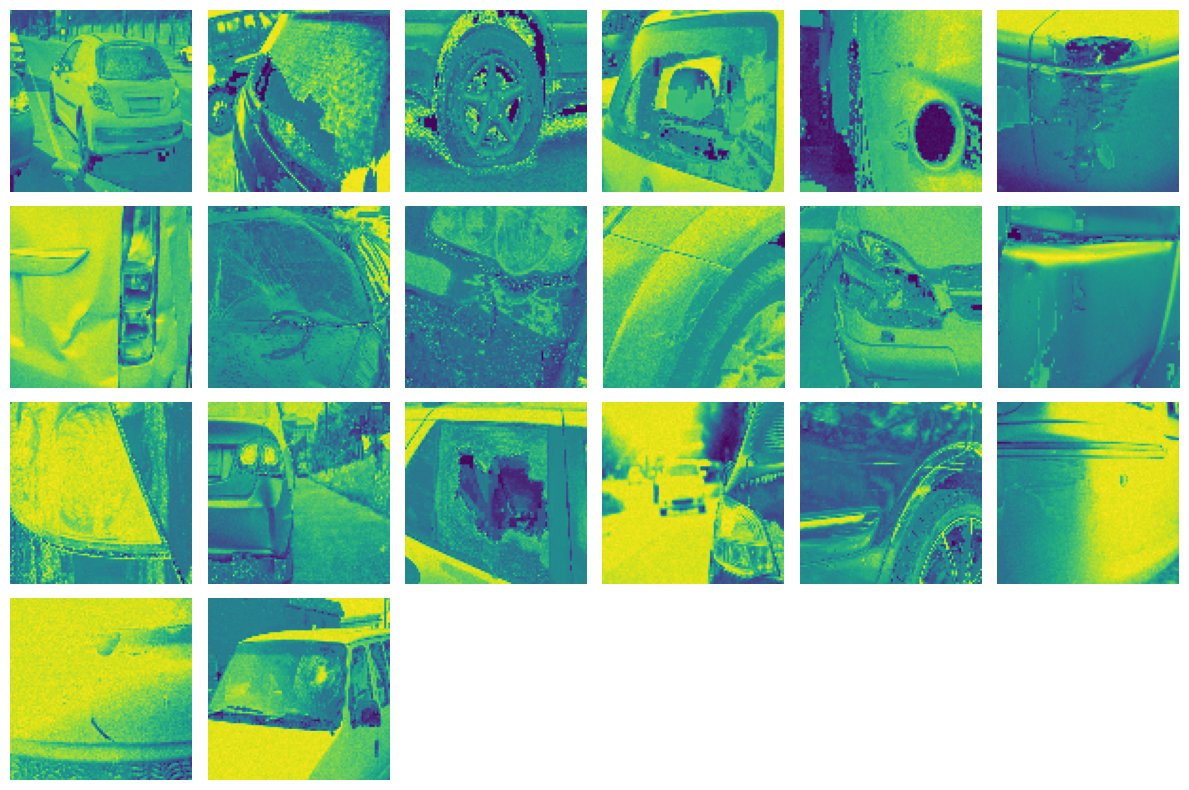

2023-12-19 21:07:12.108119: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:190] failed to create cublas handle: the resource allocation failed
2023-12-19 21:07:12.108175: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:193] Failure to initialize cublas may be due to OOM (cublas needs some free memory when you initialize it, and your deep-learning framework may have preallocated more than its fair share), or may be because this binary was not built with support for the GPU in your machine.
2023-12-19 21:07:12.128109: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:190] failed to create cublas handle: the resource allocation failed
2023-12-19 21:07:12.128156: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:193] Failure to initialize cublas may be due to OOM (cublas needs some free memory when you initialize it, and your deep-learning framework may have preallocated more than its fair share), or may be because this binary was not built with

NotFoundError: Graph execution error:

Detected at node 'sequential_29/conv2d_132/Conv2D' defined at (most recent call last):
    File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 736, in start
      self.io_loop.start()
    File "/opt/conda/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/opt/conda/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell
      await result
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_47/1278359248.py", line 73, in <module>
      y_pred = show_output(random_test_images(),model1)
    File "/tmp/ipykernel_47/1278359248.py", line 43, in show_output
      y_pred = model.predict(img_data)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 2554, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 2341, in predict_function
      return step_function(self, iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 2327, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 2315, in run_step
      outputs = model.predict_step(data)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 2283, in predict_step
      return self(x, training=False)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/sequential.py", line 405, in call
      return super().call(inputs, training=training, mask=mask)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py", line 290, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py", line 262, in convolution_op
      return tf.nn.convolution(
Node: 'sequential_29/conv2d_132/Conv2D'
No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine eng1{}: UNKNOWN: CUDNN_STATUS_ALLOC_FAILED
in tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc(5299): 'status'
  Profiling failure on CUDNN engine eng28{}: UNKNOWN: CUDNN_STATUS_ALLOC_FAILED
in tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc(5299): 'status'
  Profiling failure on CUDNN engine eng0{}: UNKNOWN: CUDNN_STATUS_ALLOC_FAILED
in tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc(5299): 'status'
  Profiling failure on CUDNN engine eng42{k2=0,k4=1,k5=1,k6=0,k7=0}: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc(5299): 'status'
  Profiling failure on CUDNN engine eng28{k2=1,k3=0}: UNKNOWN: CUDNN_STATUS_ALLOC_FAILED
in tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc(5299): 'status'
  Profiling failure on CUDNN engine eng6{}: UNKNOWN: CUDNN_STATUS_INTERNAL_ERROR
in tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc(5299): 'status'
  Profiling failure on CUDNN engine eng3{k11=2}: UNKNOWN: CUDNN_STATUS_ALLOC_FAILED
in tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc(5299): 'status'
	 [[{{node sequential_29/conv2d_132/Conv2D}}]] [Op:__inference_predict_function_8871]

In [41]:
# Model Prediction

def show_output(path_list,model):
    testout = []
    for path in path_list:
        fetched_img = cv2.imread('/kaggle/input/car-damage/test_zip/test/images/'+path,0)
        input_img_resize=cv2.resize(fetched_img,(target_size))
        testout.append(input_img_resize)
        
    color_testout = []
    for path in path_list:
        fetched_img = cv2.imread('/kaggle/input/car-damage/test_zip/test/images/'+path,1)
        input_img_resize=cv2.resize(fetched_img,(target_size))
        color_testout.append(input_img_resize)
        
    hsv_testout = []
    for path in path_list:
        fetched_img = cv2.imread(test_path + '/' + path,1)
        print(fetched_img.shape)
        converted_img = cv2.cvtColor(fetched_img, cv2.COLOR_BGR2HSV)
        converted_img = cv2.resize(converted_img,target_size)
        
        print(converted_img.shape)
        
        converted_img = converted_img[:, :, 2]
        converted_img = np.reshape(converted_img,(*target_size,1))
        print(converted_img.shape)
        print()
#         converted_img /= 255
        hsv_testout.append(converted_img)
        
    img_data = np.array(testout)  
    img_data = img_data.astype('float64')
    img_data /= 255
    
    cols = 6
    rows = (len(path_list) // cols) + 1
    
    plt.figure(figsize=(12,8))
    for idx, act_img in enumerate(hsv_testout):
        plt.subplot(rows,cols,idx+1)
        plt.imshow(act_img)
#         plt.title(str(idx+1))
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    y_pred = model.predict(img_data)
    
    final_out = []
    pos = 1
    for predicted_arr in y_pred:
        final_out.append(label_dict[np.argmax(predicted_arr)])
#         print(pos); pos += 1;
#         print('Predicted array: ',predicted_arr)
#         print('Sum:', sum(predicted_arr))
#         print('index: ',list(predicted_arr).index(max(predicted_arr)))
#         print()
    
    plt.figure(figsize=(12,8))
    idx=0
    for act_img,dis in zip(testout,final_out):
        plt.subplot(rows,cols,idx+1)
        plt.imshow(act_img)
        plt.title(dis)
        plt.axis('off')
        idx += 1
    plt.tight_layout()
    plt.show()
    return y_pred
    
def random_test_images ():
    return random.choices(os.listdir('/kaggle/input/car-damage/test_zip/test/images'),k=20)

# for idx in range(len(random_test_images)):
#     random_test_images[idx] = '/kaggle/input/car-damage/test_zip/test/images/'+ random_test_images[idx]

y_pred = show_output(random_test_images(),model1)

In [1]:
# # To be removed

# for i in range(y_pred.shape[0]):
#     display(y_pred[i])
#     display(np.argmax(y_pred[i]))
#     print('max: ',max(list(y_pred[i])),' sum = ',sum(list(y_pred[i])))
#     print()

# Prediction on Test Data

In [ ]:
test_path = '/kaggle/input/car-damage/test_zip/test'

test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_path,
                                                    target_size=(255,255),
                                                    batch_size= 48,
                                                    class_mode = None,
                                                    shuffle = False)

test_pred = model.predict(test_generator)

image_paths = test_generator.filenames    

test_df = pd.read_csv(test_path + '/test.csv')

temp = pd.DataFrame()
sub_df = pd.DataFrame()

test_labels = []
for pred_arr in test_pred:
    test_labels.append(np.argmax(pred_arr)+1)

temp['image_path'] = image_paths
temp['label'] = test_labels
temp['image_path'] = temp['image_path'].str.split('/',expand=True)[1].str.split('.',expand=True)[0].astype(int)

sub_df['image_id'] = test_df['image_id']
sub_df['label'] = 0

label_list = []
for image_id in sub_df['image_id']:
    label_list.append(temp['label'][temp['image_path'] == image_id].to_numpy()[0])
    
sub_df['label'] = label_list

In [ ]:
sub_df.to_csv('sub_mobilenet_increase_info_epoch16.csv',index=False)
sub_df.head()

In [ ]:
# sub_df['label'].value_counts().sum()

In [ ]:
# arr = np.array([1.2,1.3,0.9,0.6,0.66,0.92])
# print(list(arr).index(max(list(arr))))
# print(np.argmax(arr))